In [1]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import os
import pandas as pd


In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from tqdm import tqdm
from torch import nn
import torchvision.models as models


In [3]:
import os
print(os.getcwd())

os.chdir('/Users/linchenwei/Desktop/OMSCS_DL/Group Project/CS7643_project')

/Users/linchenwei/Desktop/OMSCS_DL/Group Project/CS7643_project


In [4]:
loaded_model = torch.load("model/model_20241131_resnet50.pth")

In [5]:
local_dir='/Users/linchenwei/Desktop/OMSCS_DL/Group Project/CS7643_project/data/'
train_labels = pd.read_csv(local_dir + "train_labels.csv", index_col="id")
species_labels = sorted(train_labels.columns.unique())
species_labels

['antelope_duiker',
 'bird',
 'blank',
 'civet_genet',
 'hog',
 'leopard',
 'monkey_prosimian',
 'rodent']

In [18]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms


class ImagesDataset(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """

    def __init__(self, x_df, y_df=None):
        self.data = x_df
        self.label = y_df
        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(),
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __getitem__(self, index):
        image = Image.open(self.data.iloc[index]["filepath"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.index[index]
        # if we don't have labels (e.g. for test set) just return the image and image id
        if self.label is None:
            sample = {"image_id": image_id, "image": image}
        else:
            label = torch.tensor(self.label.iloc[index].values, 
                                 dtype=torch.float)
            sample = {"image_id": image_id, "image": image, "label": label}
        return sample

    def __len__(self):
        return len(self.data)

In [19]:
train_features = pd.read_csv(local_dir + "train_features.csv", index_col="id")
test_features = pd.read_csv(local_dir + "test_features.csv", index_col="id")
train_labels = pd.read_csv(local_dir + "train_labels.csv", index_col="id")

In [20]:
from torch.utils.data import DataLoader
from torch import nn


In [21]:
from sklearn.model_selection import train_test_split

import yaml

# Load the YAML configuration
with open("configs/config.yaml", "r") as file:
    config = yaml.safe_load(file)

# Extract parameters
frac = config['data_split']['frac']
test_size = config['data_split']['test_size']


y = train_labels.sample(frac=frac, random_state=1)
x = train_features.loc[y.index].filepath.to_frame()

# note that we are casting the species labels to an indicator/dummy matrix
x_train, x_eval, y_train, y_eval = train_test_split(
    x, y, stratify=y, test_size=0.25
)

In [22]:
eval_dataset = ImagesDataset(x_eval, y_eval)
eval_dataloader = DataLoader(eval_dataset, batch_size=32)

In [24]:
os.chdir('/Users/linchenwei/Desktop/OMSCS_DL/Group Project/CS7643_project/data')
preds_collector = []
model = loaded_model
# put the model in eval mode so we don't update any parameters
model.eval()

# we aren't updating our weights so no need to calculate gradients
with torch.no_grad():
    for batch in tqdm(eval_dataloader, total=len(eval_dataloader)):
        # 1) run the forward step
        logits = model.forward(batch["image"])
        # 2) apply softmax so that model outputs are in range [0,1]
        preds = nn.functional.softmax(logits, dim=1)
        # 3) store this batch's predictions in df
        # note that PyTorch Tensors need to first be detached from their computational graph before converting to numpy arrays
        preds_df = pd.DataFrame(
            preds.detach().numpy(),
            index=batch["image_id"],
            columns=species_labels,
        )
        preds_collector.append(preds_df)

eval_preds_df = pd.concat(preds_collector)
eval_preds_df

100%|██████████| 104/104 [03:52<00:00,  2.23s/it]


,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent
ZJ005818,3.699863e-04,9.932867e-01,1.667327e-04,3.165722e-07,1.171741e-05,5.928089e-06,5.394344e-03,7.642046e-04
ZJ007699,4.064527e-04,9.576562e-07,6.836752e-04,7.638850e-04,2.282301e-03,9.957491e-01,1.131627e-04,5.253582e-07
ZJ007856,7.897936e-02,1.817236e-04,2.498054e-03,3.470483e-05,7.302558e-03,8.405272e-03,9.025921e-01,6.189740e-06
ZJ000625,2.782855e-05,2.043505e-06,9.999574e-01,1.014466e-07,2.203322e-07,1.075366e-05,9.678664e-07,6.213093e-07
ZJ005109,2.232374e-04,1.835560e-04,2.426568e-05,3.360588e-05,2.943662e-07,7.245051e-07,3.214452e-06,9.995311e-01
...,...,...,...,...,...,...,...,...
ZJ007310,1.067397e-02,4.672913e-03,6.438094e-01,2.519799e-03,2.166903e-01,1.800434e-02,1.024486e-01,1.180716e-03
ZJ002605,2.751751e-05,1.509551e-10,6.215491e-08,9.999557e-01,3.807450e-07,3.107175e-08,2.791201e-07,1.619973e-05
ZJ015763,9.995043e-01,1.259177e-05,1.243699e-04,6.159558e-05,1.543760e-06,3.665796e-08,4.239250e-06,2.912491e-04
ZJ014664,5.306964e-07,2.374640e-08,3.388028e-06,9.999932e-01,2.182608e-07,1.280065e-07,2.901506e-08,2.485376e-06


In [25]:
eval_preds_df['predicted_class'] = eval_preds_df.iloc[:, 0:].idxmax(axis=1)
eval_preds_df

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class
ZJ005818,3.699863e-04,9.932867e-01,1.667327e-04,3.165722e-07,1.171741e-05,5.928089e-06,5.394344e-03,7.642046e-04,bird
ZJ007699,4.064527e-04,9.576562e-07,6.836752e-04,7.638850e-04,2.282301e-03,9.957491e-01,1.131627e-04,5.253582e-07,leopard
ZJ007856,7.897936e-02,1.817236e-04,2.498054e-03,3.470483e-05,7.302558e-03,8.405272e-03,9.025921e-01,6.189740e-06,monkey_prosimian
ZJ000625,2.782855e-05,2.043505e-06,9.999574e-01,1.014466e-07,2.203322e-07,1.075366e-05,9.678664e-07,6.213093e-07,blank
ZJ005109,2.232374e-04,1.835560e-04,2.426568e-05,3.360588e-05,2.943662e-07,7.245051e-07,3.214452e-06,9.995311e-01,rodent
...,...,...,...,...,...,...,...,...,...
ZJ007310,1.067397e-02,4.672913e-03,6.438094e-01,2.519799e-03,2.166903e-01,1.800434e-02,1.024486e-01,1.180716e-03,blank
ZJ002605,2.751751e-05,1.509551e-10,6.215491e-08,9.999557e-01,3.807450e-07,3.107175e-08,2.791201e-07,1.619973e-05,civet_genet
ZJ015763,9.995043e-01,1.259177e-05,1.243699e-04,6.159558e-05,1.543760e-06,3.665796e-08,4.239250e-06,2.912491e-04,antelope_duiker
ZJ014664,5.306964e-07,2.374640e-08,3.388028e-06,9.999932e-01,2.182608e-07,1.280065e-07,2.901506e-08,2.485376e-06,civet_genet


In [2]:
import pandas as pd
import os

os.chdir('/Users/linchenwei/Desktop/OMSCS_DL/Group Project/CS7643_project')

450

In [28]:
#eval_preds_df.to_excel('predictions.xlsx')

In [11]:

eval_preds_df=pd.read_excel('predictions.xlsx')

In [12]:
eval_preds_df

,Unnamed: 0,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class
0,ZJ005818,3.699863e-04,9.932867e-01,1.667327e-04,3.165722e-07,1.171741e-05,5.928089e-06,5.394344e-03,7.642046e-04,bird
1,ZJ007699,4.064527e-04,9.576562e-07,6.836752e-04,7.638850e-04,2.282301e-03,9.957491e-01,1.131627e-04,5.253582e-07,leopard
2,ZJ007856,7.897936e-02,1.817236e-04,2.498054e-03,3.470483e-05,7.302558e-03,8.405272e-03,9.025921e-01,6.189740e-06,monkey_prosimian
3,ZJ000625,2.782855e-05,2.043505e-06,9.999574e-01,1.014466e-07,2.203322e-07,1.075366e-05,9.678664e-07,6.213093e-07,blank
4,ZJ005109,2.232374e-04,1.835560e-04,2.426568e-05,3.360588e-05,2.943662e-07,7.245051e-07,3.214452e-06,9.995311e-01,rodent
...,...,...,...,...,...,...,...,...,...,...
3293,ZJ007310,1.067397e-02,4.672913e-03,6.438094e-01,2.519799e-03,2.166903e-01,1.800434e-02,1.024486e-01,1.180716e-03,blank
3294,ZJ002605,2.751751e-05,1.509551e-10,6.215491e-08,9.999557e-01,3.807450e-07,3.107175e-08,2.791201e-07,1.619973e-05,civet_genet
3295,ZJ015763,9.995043e-01,1.259177e-05,1.243699e-04,6.159558e-05,1.543760e-06,3.665796e-08,4.239250e-06,2.912491e-04,antelope_duiker
3296,ZJ014664,5.306964e-07,2.374640e-08,3.388028e-06,9.999932e-01,2.182608e-07,1.280065e-07,2.901506e-08,2.485376e-06,civet_genet


In [33]:
sum(eval_preds_df['predicted_class']=="antelope_duiker")

450

In [5]:
from sklearn.cluster import KMeans



In [6]:
# Perform clustering
X = eval_preds_df.iloc[:, 1:-1].values  # Exclude ID and predicted class


array([4.06452746e-04, 9.57656198e-07, 6.83675171e-04, 7.63884978e-04,
       2.28230143e-03, 9.95749116e-01, 1.13162685e-04, 5.25358246e-07])

In [7]:
kmeans = KMeans(n_clusters=8, random_state=42)


In [8]:
eval_preds_df["cluster"]=kmeans.fit_predict(X)

In [9]:
#eval_preds_df.to_excel("data/eval_preds_df_clusters.xlsx",index=False)

In [11]:
eval_preds_df=pd.read_excel('data/eval_preds_df_clusters.xlsx')

In [12]:
eval_preds_df

,Unnamed: 0,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class,cluster
0,ZJ005818,3.699863e-04,9.932867e-01,1.667327e-04,3.165722e-07,1.171741e-05,5.928089e-06,5.394344e-03,7.642046e-04,bird,6
1,ZJ007699,4.064527e-04,9.576562e-07,6.836752e-04,7.638850e-04,2.282301e-03,9.957491e-01,1.131627e-04,5.253582e-07,leopard,4
2,ZJ007856,7.897936e-02,1.817236e-04,2.498054e-03,3.470483e-05,7.302558e-03,8.405272e-03,9.025921e-01,6.189740e-06,monkey_prosimian,3
3,ZJ000625,2.782855e-05,2.043505e-06,9.999574e-01,1.014466e-07,2.203322e-07,1.075366e-05,9.678664e-07,6.213093e-07,blank,2
4,ZJ005109,2.232374e-04,1.835560e-04,2.426568e-05,3.360588e-05,2.943662e-07,7.245051e-07,3.214452e-06,9.995311e-01,rodent,0
...,...,...,...,...,...,...,...,...,...,...,...
3293,ZJ007310,1.067397e-02,4.672913e-03,6.438094e-01,2.519799e-03,2.166903e-01,1.800434e-02,1.024486e-01,1.180716e-03,blank,2
3294,ZJ002605,2.751751e-05,1.509551e-10,6.215491e-08,9.999557e-01,3.807450e-07,3.107175e-08,2.791201e-07,1.619973e-05,civet_genet,1
3295,ZJ015763,9.995043e-01,1.259177e-05,1.243699e-04,6.159558e-05,1.543760e-06,3.665796e-08,4.239250e-06,2.912491e-04,antelope_duiker,5
3296,ZJ014664,5.306964e-07,2.374640e-08,3.388028e-06,9.999932e-01,2.182608e-07,1.280065e-07,2.901506e-08,2.485376e-06,civet_genet,1


In [13]:
value_counts = {k: dict(v) for k, v in eval_preds_df.groupby('cluster')['predicted_class'].value_counts().groupby(level=0)}
value_counts 

{0: {(0, 'rodent'): 362},
 1: {(1, 'civet_genet'): 478},
 2: {(2, 'blank'): 511,
  (2, 'rodent'): 4,
  (2, 'antelope_duiker'): 2,
  (2, 'hog'): 2,
  (2, 'leopard'): 2,
  (2, 'monkey_prosimian'): 2,
  (2, 'bird'): 1},
 3: {(3, 'monkey_prosimian'): 470},
 4: {(4, 'leopard'): 445},
 5: {(5, 'antelope_duiker'): 448},
 6: {(6, 'bird'): 375},
 7: {(7, 'hog'): 196}}

In [14]:
# Value counts dict
value_counts = {k: dict(v) for k, v in eval_preds_df.groupby('cluster')['predicted_class'].value_counts().groupby(level=0)}

# Crosstab dict 
crosstab = pd.crosstab(eval_preds_df['cluster'], eval_preds_df['predicted_class']).to_dict()

# Most common dict
most_common = {cluster: eval_preds_df[eval_preds_df['cluster'] == cluster]['predicted_class'].mode()[0] 
              for cluster in eval_preds_df['cluster'].unique()}

most_common

{6: 'bird',
 4: 'leopard',
 3: 'monkey_prosimian',
 2: 'blank',
 0: 'rodent',
 5: 'antelope_duiker',
 1: 'civet_genet',
 7: 'hog'}

In [15]:
class_names = most_common



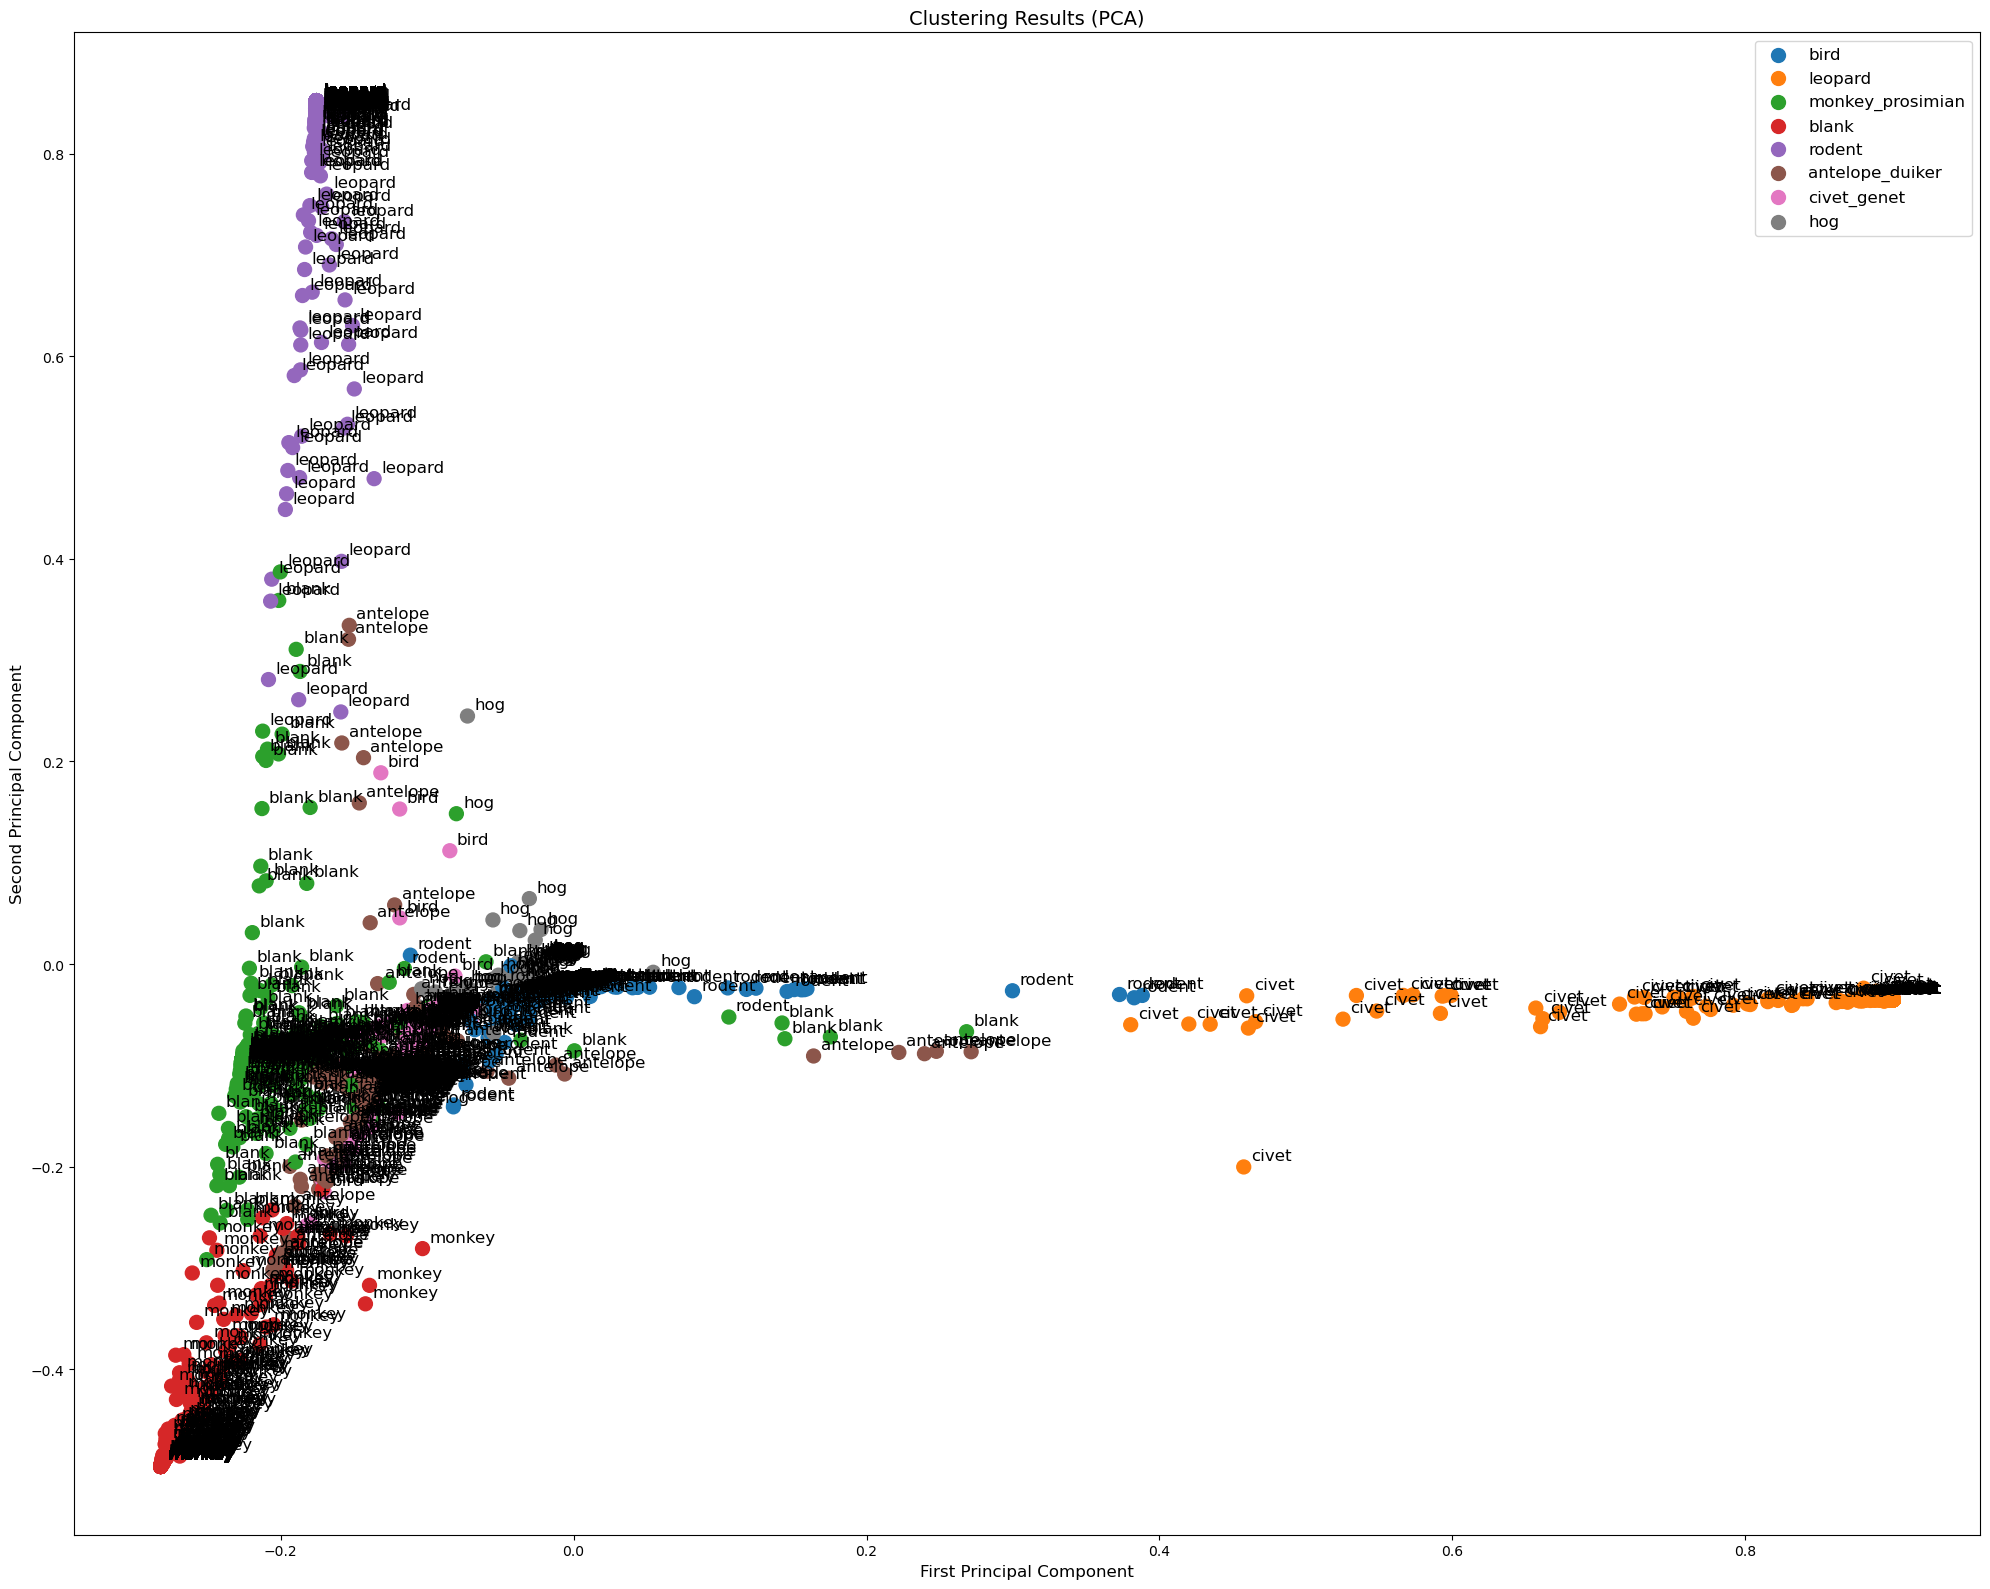

In [16]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
# PCA for visualization 
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X) # Map numeric clusters to distinct colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
cluster_colors = {i: color for i, color in enumerate(colors)}


plt.figure(figsize=(20, 16))  # Increase figure size
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], 
                    c=[cluster_colors[i] for i in eval_preds_df['cluster']],
                    s=100)  # Increase point size

# Add labels with offset and bigger font
for i, txt in enumerate(eval_preds_df.index):
   plt.annotate(eval_preds_df['predicted_class'].iloc[i].split('_')[0],
               (X_pca[i, 0], X_pca[i, 1]),
               xytext=(5, 5),  # Add offset to labels
               textcoords='offset points',
               fontsize=12)  # Increase font size

plt.title('Clustering Results (PCA)', fontsize=14)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.legend(handles=[plt.scatter([], [], c=color, label=class_name, s=100) 
                  for class_name, color in zip(class_names.values(), colors)],
          fontsize=12)

plt.tight_layout()
plt.show()

# make the model trained on 8 classes predict tiger

In [7]:
os.chdir('/Users/linchenwei/Desktop/OMSCS_DL/Group Project/CS7643_project/data')

model = torch.load("../model/model_20241131_resnet50.pth")

def predict_image(image_path, model):
   transform = transforms.Compose([
       transforms.Resize((224, 224)),
       transforms.ToTensor(),
       transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
   ])
   
   img = Image.open(image_path).convert('RGB')
   img_tensor = transform(img).unsqueeze(0)
   
   model.eval()
   with torch.no_grad():
       logits = model(img_tensor)
       preds = nn.functional.softmax(logits, dim=1)
   
   return preds.numpy()

# Usage:
image_paths = ['elephant_1.jpg', 'elephant_2.jpg', 'elephant_3.jpg', 'elephant_4.jpg','elephant_5.jpg']
predictions = []

for path in image_paths:
   pred = predict_image(path, model)
   predictions.append(pred[0])  # Get first row since batch size is 1

results_df = pd.DataFrame(predictions, 
                        columns=species_labels)
print(results_df)

   antelope_duiker      bird     blank   civet_genet       hog   leopard  \
0         0.017685  0.014059  0.031155  1.914293e-04  0.006287  0.168800   
1         0.015500  0.000706  0.015846  3.661654e-07  0.961731  0.004704   
2         0.051896  0.025355  0.007514  3.541030e-05  0.038299  0.009337   
3         0.001104  0.747570  0.201862  8.552849e-06  0.001229  0.040796   
4         0.006842  0.633616  0.179814  2.666644e-04  0.045339  0.064525   

   monkey_prosimian        rodent  
0          0.760134  1.689039e-03  
1          0.001512  1.880637e-07  
2          0.867177  3.865348e-04  
3          0.004237  3.192715e-03  
4          0.061052  8.543978e-03  


In [8]:
results_df['predicted_class'] = results_df.iloc[:, 1:].idxmax(axis=1)


In [13]:
eval_preds_df.iloc[:,1:10]

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class
0,3.699863e-04,9.932867e-01,1.667327e-04,3.165722e-07,1.171741e-05,5.928089e-06,5.394344e-03,7.642046e-04,bird
1,4.064527e-04,9.576562e-07,6.836752e-04,7.638850e-04,2.282301e-03,9.957491e-01,1.131627e-04,5.253582e-07,leopard
2,7.897936e-02,1.817236e-04,2.498054e-03,3.470483e-05,7.302558e-03,8.405272e-03,9.025921e-01,6.189740e-06,monkey_prosimian
3,2.782855e-05,2.043505e-06,9.999574e-01,1.014466e-07,2.203322e-07,1.075366e-05,9.678664e-07,6.213093e-07,blank
4,2.232374e-04,1.835560e-04,2.426568e-05,3.360588e-05,2.943662e-07,7.245051e-07,3.214452e-06,9.995311e-01,rodent
...,...,...,...,...,...,...,...,...,...
3293,1.067397e-02,4.672913e-03,6.438094e-01,2.519799e-03,2.166903e-01,1.800434e-02,1.024486e-01,1.180716e-03,blank
3294,2.751751e-05,1.509551e-10,6.215491e-08,9.999557e-01,3.807450e-07,3.107175e-08,2.791201e-07,1.619973e-05,civet_genet
3295,9.995043e-01,1.259177e-05,1.243699e-04,6.159558e-05,1.543760e-06,3.665796e-08,4.239250e-06,2.912491e-04,antelope_duiker
3296,5.306964e-07,2.374640e-08,3.388028e-06,9.999932e-01,2.182608e-07,1.280065e-07,2.901506e-08,2.485376e-06,civet_genet


In [14]:
all_prediction = pd.concat([eval_preds_df.iloc[:,1:10], results_df],ignore_index=True)

all_prediction 

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class
0,0.000370,9.932867e-01,0.000167,3.165722e-07,1.171741e-05,5.928089e-06,5.394344e-03,7.642046e-04,bird
1,0.000406,9.576562e-07,0.000684,7.638850e-04,2.282301e-03,9.957491e-01,1.131627e-04,5.253582e-07,leopard
2,0.078979,1.817236e-04,0.002498,3.470483e-05,7.302558e-03,8.405272e-03,9.025921e-01,6.189740e-06,monkey_prosimian
3,0.000028,2.043505e-06,0.999957,1.014466e-07,2.203322e-07,1.075366e-05,9.678664e-07,6.213093e-07,blank
4,0.000223,1.835560e-04,0.000024,3.360588e-05,2.943662e-07,7.245051e-07,3.214452e-06,9.995311e-01,rodent
...,...,...,...,...,...,...,...,...,...
3298,0.017685,1.405937e-02,0.031155,1.914293e-04,6.286696e-03,1.687998e-01,7.601340e-01,1.689039e-03,monkey_prosimian
3299,0.015500,7.057707e-04,0.015846,3.661654e-07,9.617312e-01,4.704196e-03,1.512417e-03,1.880637e-07,hog
3300,0.051896,2.535510e-02,0.007514,3.541030e-05,3.829863e-02,9.337459e-03,8.671774e-01,3.865348e-04,monkey_prosimian
3301,0.001104,7.475700e-01,0.201862,8.552849e-06,1.229266e-03,4.079585e-02,4.237375e-03,3.192715e-03,bird


In [16]:

all_prediction.to_excel("all_predictions.xlsx",index=False)

In [17]:
import os
import pandas as pd
os.chdir('/Users/linchenwei/Desktop/OMSCS_DL/Group Project/CS7643_project')

all_prediction= pd.read_excel('data/all_predictions.xlsx')

In [18]:
from sklearn.cluster import KMeans

all_prediction

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class
0,0.000370,9.932867e-01,0.000167,3.165722e-07,1.171741e-05,5.928089e-06,5.394344e-03,7.642046e-04,bird
1,0.000406,9.576562e-07,0.000684,7.638850e-04,2.282301e-03,9.957491e-01,1.131627e-04,5.253582e-07,leopard
2,0.078979,1.817236e-04,0.002498,3.470483e-05,7.302558e-03,8.405272e-03,9.025921e-01,6.189740e-06,monkey_prosimian
3,0.000028,2.043505e-06,0.999957,1.014466e-07,2.203322e-07,1.075366e-05,9.678664e-07,6.213093e-07,blank
4,0.000223,1.835560e-04,0.000024,3.360588e-05,2.943662e-07,7.245051e-07,3.214452e-06,9.995311e-01,rodent
...,...,...,...,...,...,...,...,...,...
3298,0.017685,1.405937e-02,0.031155,1.914293e-04,6.286696e-03,1.687998e-01,7.601340e-01,1.689039e-03,monkey_prosimian
3299,0.015500,7.057707e-04,0.015846,3.661654e-07,9.617312e-01,4.704196e-03,1.512417e-03,1.880637e-07,hog
3300,0.051896,2.535510e-02,0.007514,3.541030e-05,3.829863e-02,9.337459e-03,8.671774e-01,3.865348e-04,monkey_prosimian
3301,0.001104,7.475700e-01,0.201862,8.552849e-06,1.229266e-03,4.079585e-02,4.237375e-03,3.192715e-03,bird


In [19]:
X = all_prediction .iloc[:, 0:-1].values  # Exclude ID and predicted class

In [20]:

kmeans = KMeans(n_clusters=8, random_state=42)


In [21]:

all_prediction["cluster"]=kmeans.fit_predict(X)

: 

: 

In [38]:
all_prediction

,antelope_duiker,bird,blank,civet_genet,hog,leopard,monkey_prosimian,rodent,predicted_class,cluster
0,0.000370,9.932867e-01,0.000167,3.165722e-07,1.171741e-05,5.928089e-06,5.394344e-03,7.642046e-04,bird,5
1,0.000406,9.576562e-07,0.000684,7.638850e-04,2.282301e-03,9.957491e-01,1.131627e-04,5.253582e-07,leopard,7
2,0.078979,1.817236e-04,0.002498,3.470483e-05,7.302558e-03,8.405272e-03,9.025921e-01,6.189740e-06,monkey_prosimian,4
3,0.000028,2.043505e-06,0.999957,1.014466e-07,2.203322e-07,1.075366e-05,9.678664e-07,6.213093e-07,blank,2
4,0.000223,1.835560e-04,0.000024,3.360588e-05,2.943662e-07,7.245051e-07,3.214452e-06,9.995311e-01,rodent,3
...,...,...,...,...,...,...,...,...,...,...
3298,0.000024,1.434821e-04,0.001150,1.155981e-03,1.616424e-04,9.971149e-01,1.370059e-04,1.124045e-04,leopard,7
3299,0.282426,8.261616e-03,0.598230,1.517975e-03,9.324550e-03,9.423463e-02,3.720267e-03,2.284866e-03,blank,2
3300,0.000248,7.629881e-05,0.105495,1.095790e-05,2.051027e-06,8.941554e-01,7.343286e-06,4.592078e-06,leopard,7
3301,0.017704,5.703315e-01,0.045991,8.557033e-04,2.349808e-01,4.974572e-02,2.003190e-02,6.035952e-02,bird,5


In [39]:
# Value counts dict
value_counts = {k: dict(v) for k, v in all_prediction.groupby('cluster')['predicted_class'].value_counts().groupby(level=0)}

# Crosstab dict 
crosstab = pd.crosstab(all_prediction['cluster'], all_prediction['predicted_class']).to_dict()

# Most common dict
most_common = {cluster: all_prediction[all_prediction['cluster'] == cluster]['predicted_class'].mode()[0] 
              for cluster in all_prediction['cluster'].unique()}

most_common

{5: 'bird',
 7: 'leopard',
 4: 'monkey_prosimian',
 2: 'blank',
 3: 'rodent',
 6: 'antelope_duiker',
 1: 'civet_genet',
 0: 'hog'}

In [40]:
class_names =most_common

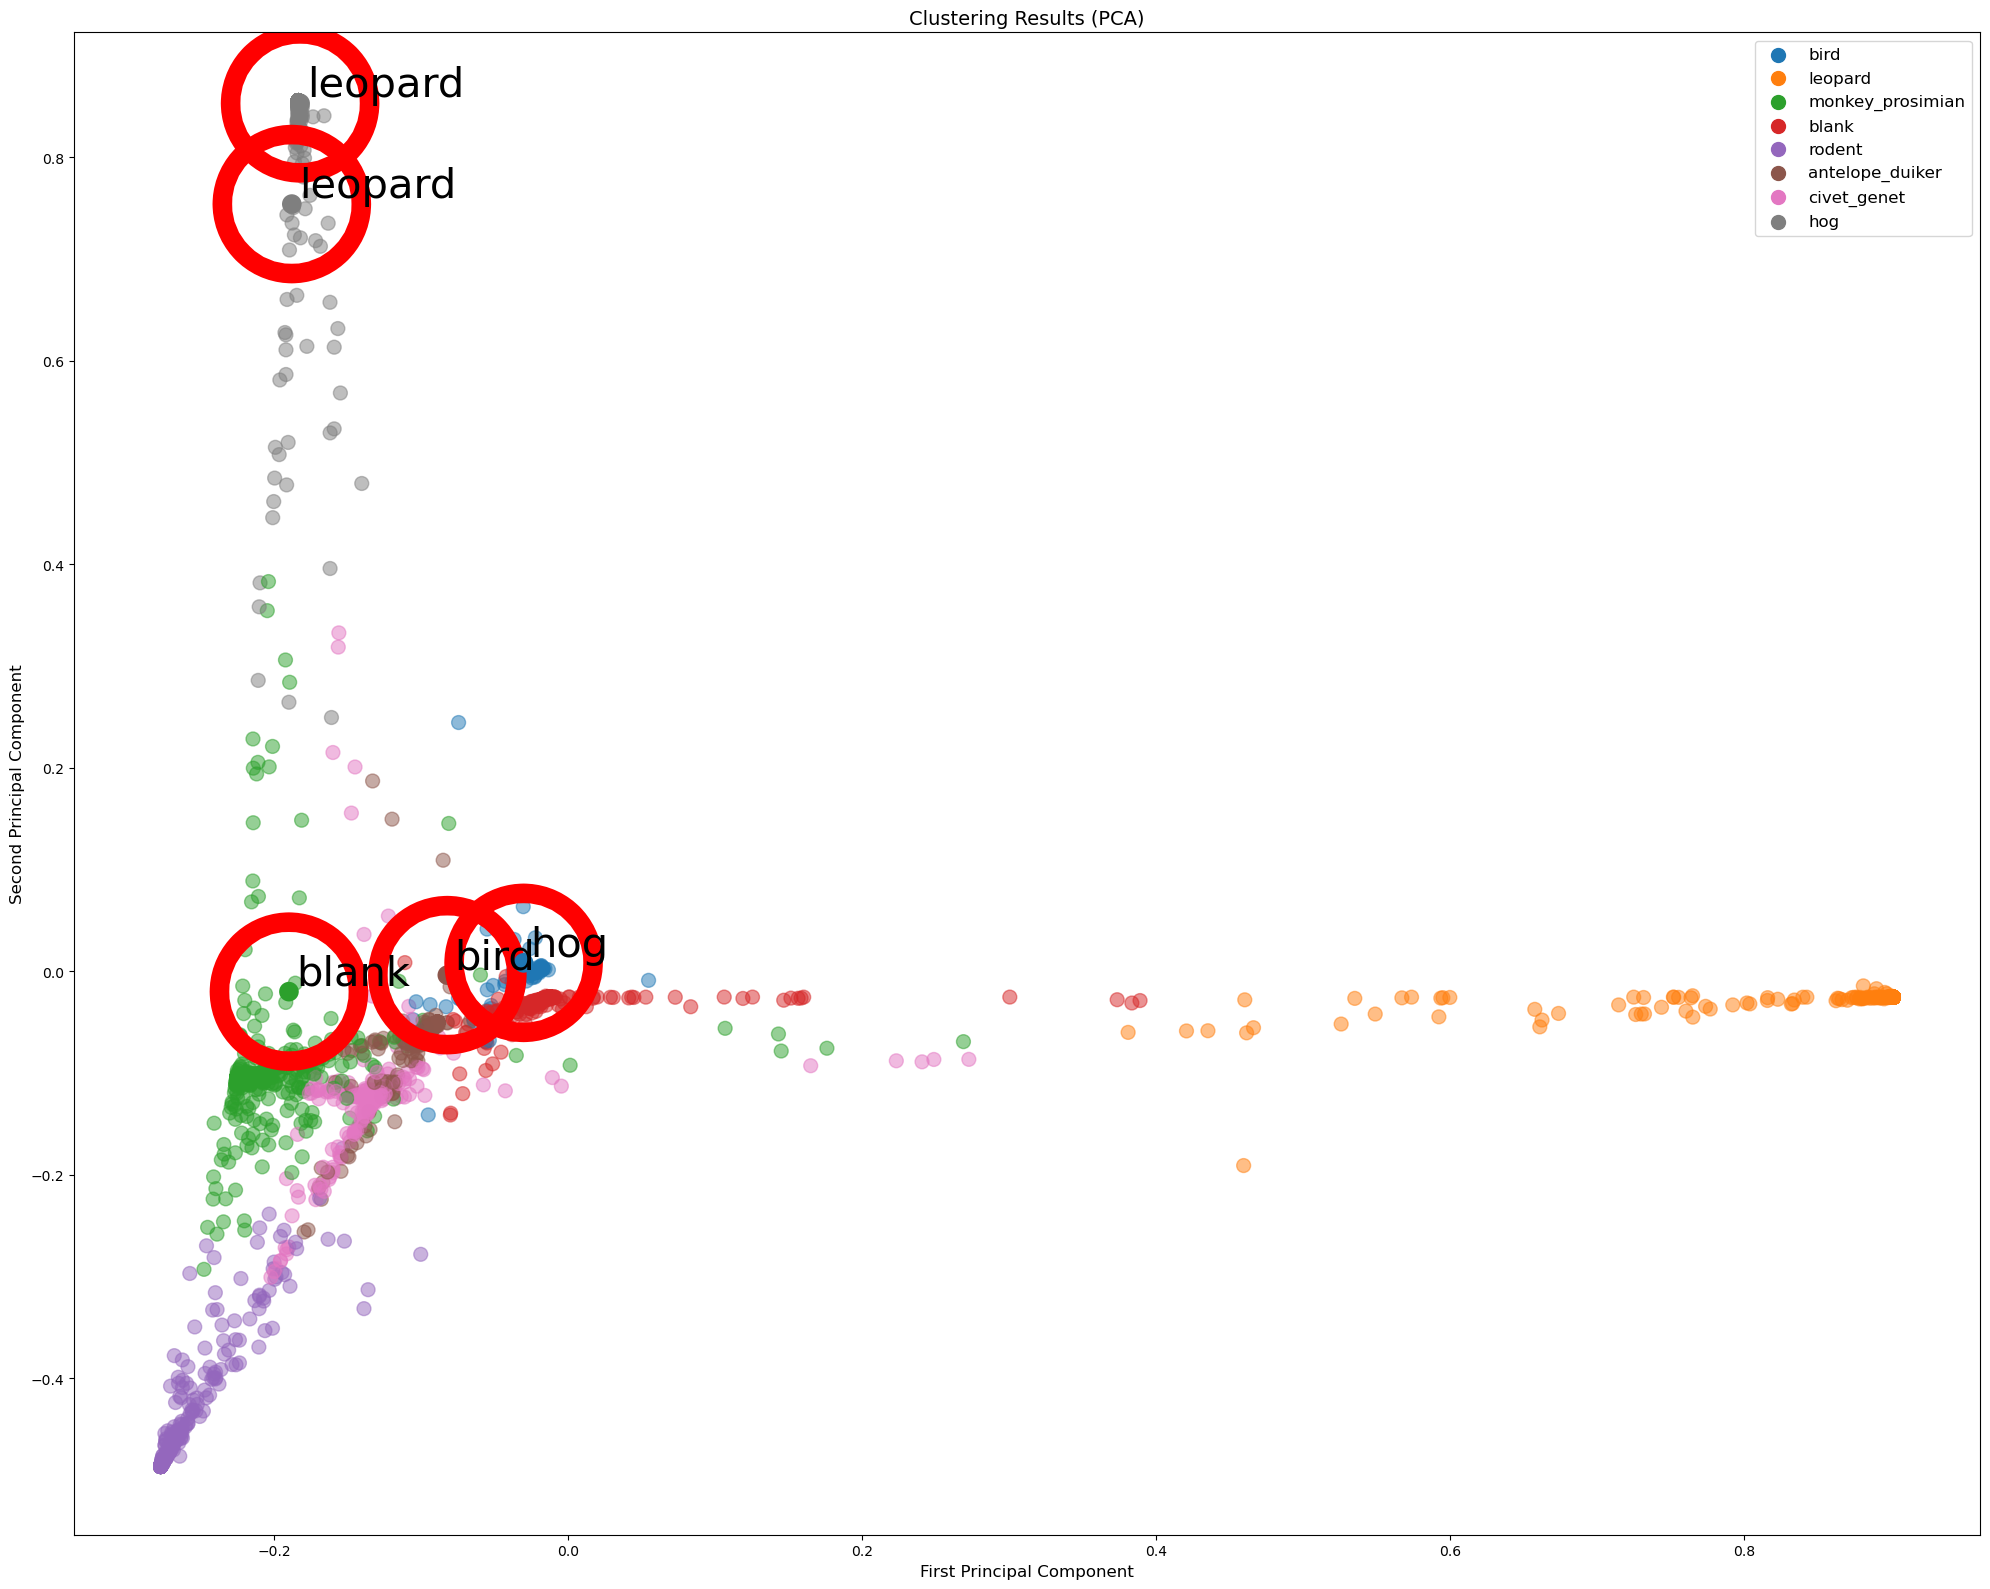

In [42]:

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
# PCA for visualization 
pca = PCA(n_components=2) 
X_pca = pca.fit_transform(X) # Map numeric clusters to distinct colors
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']
cluster_colors = {i: color for i, color in enumerate(colors)}

# Choose indices to highlight
highlight_indices = [3298,3299, 3300,3301,3302]  # Replace with  tigers

plt.figure(figsize=(20, 16))

# Plot regular points
mask = ~np.isin(range(len(X_pca)), highlight_indices)
plt.scatter(X_pca[mask, 0], X_pca[mask, 1],
          c=[cluster_colors[i] for i in all_prediction['cluster'][mask]],
          s=100, alpha=0.5)

# Plot highlighted points
plt.scatter(X_pca[highlight_indices, 0], X_pca[highlight_indices, 1],
          c=[cluster_colors[i] for i in all_prediction['cluster'][highlight_indices]],
          s=200, edgecolor='red', linewidth=100)

#Rest of your plotting code remains same
for i, txt in enumerate(all_prediction.index):
    if i in highlight_indices:  # Only annotate if index is highlighted
        plt.annotate(all_prediction['predicted_class'].iloc[i].split('_')[0],
                    (X_pca[i, 0], X_pca[i, 1]),
                    xytext=(5, 5), 
                    textcoords='offset points',
                    fontsize=30)

plt.title('Clustering Results (PCA)', fontsize=14)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.legend(handles=[plt.scatter([], [], c=color, label=class_name, s=100)
                  for class_name, color in zip(class_names.values(), colors)],
         fontsize=12)
plt.tight_layout()
plt.show()